In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Burgers
problem = Burgers()

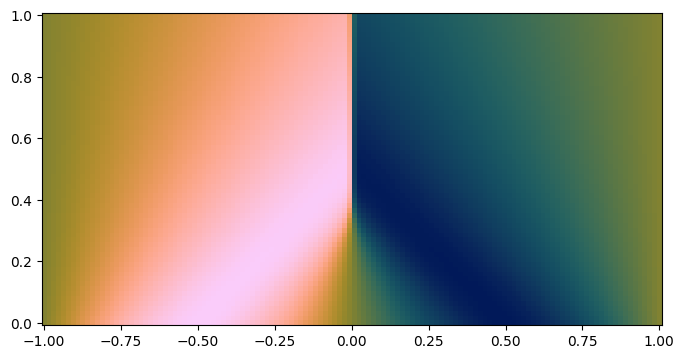

In [3]:
X, T, u_solution = problem.exact_solution(nx=128, nt=64)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

# Optimiser

In [ ]:
class HungryLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 0.75,
        increase_factor: float = 1.25,
        aggressive_factor: float = 0.75,
        max_trials: int = 100,
        steps_before_aggressive: int = 10,
        required_gain_before_aggressive: float = 0.9,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.aggressive_factor = aggressive_factor
        self.max_trials = max_trials
        self.steps_before_aggressive = steps_before_aggressive
        self.required_gain_before_aggressive = required_gain_before_aggressive

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
            'loss_history': jnp.full((self.steps_before_aggressive,), jnp.inf),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        current_lambda = state['lambda']
        loss_history = state["loss_history"]
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)
        
        # --- Update history and get the 'high-water mark' reference loss ---
        new_loss_history = jnp.roll(loss_history, shift=-1).at[-1].set(current_loss)
        reference_loss = jnp.max(new_loss_history)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        g = U.T @ residuals

        def _aggressive_step(c_lambda):
            """
            Branch 1: Not enough progress was made.
            """
            trial_lambda = c_lambda / self.decrease_factor * self.aggressive_factor
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
            # We "accept" this forced step and report its lambda.
            return True, trial_lambda, delta, 1

        def _regular_lm_search(c_lambda):
            """
            Branch 2: Progress is good.
            """
            def evaluate_trial_step(loop_val):
                _, trial_lambda, _, trial_count = loop_val
                delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
                
                trial_params = eqx.apply_updates(params, unflatten(delta))
                trial_residuals = residual_fn(trial_params)
                trial_loss = jnp.mean(trial_residuals**2)

                accepted = trial_loss < current_loss
                
                # If rejected, increase lambda for the next trial
                new_lambda = jax.lax.cond(
                    accepted,
                    lambda: trial_lambda,
                    lambda: trial_lambda * self.increase_factor
                )
                
                return accepted, new_lambda, delta, trial_count + 1

            def continue_search(loop_val):
                # Continue if step not accepted AND we haven't exceeded max trials
                accepted, _, _, trial_count = loop_val
                return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)
            
            # Run the search loop
            initial_loop_val = (False, c_lambda, jnp.zeros_like(params_flat), 0)
            accepted, final_lambda, final_delta, count = jax.lax.while_loop(
                continue_search, evaluate_trial_step, initial_loop_val
            )
            return accepted, final_lambda, final_delta, count


        not_enough_progress = current_loss > self.required_gain_before_aggressive * reference_loss

        step_was_accepted, final_lambda, lm_delta, trial_count = jax.lax.cond(
            not_enough_progress,
            _aggressive_step,
            _regular_lm_search,
            operand=current_lambda
        )

        updates = unflatten(lm_delta)
        
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
            'loss_history': jax.lax.cond(
                not_enough_progress,
                lambda: jnp.full((self.steps_before_aggressive,), 1e10),
                lambda: new_loss_history
            )
        }
        
        metrics = { 
            'loss': current_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(lm_delta),
            'lambda': final_lambda,
            'not_enough_progress': not_enough_progress,
            'trial_count': trial_count
        }

        return current_loss, updates, new_state, metrics
    
    
@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, key):
    
    key, subkey = jax.random.split(key)

    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics, key

@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def resample_rad(
    model, 
    candidate_points, 
    n_points_to_sample, 
    problem, # Pass the problem instance for its residual function
    k, # RAD hyperparameter
    c, # RAD hyperparameter
    key
):
    """
    Resamples collocation points from a candidate pool using the RAD strategy.
    """
    # 1. Calculate PDE residuals for all candidate points
    residuals = problem.physics_residual(problem.residual_fn, model, candidate_points)
    
    # 2. Compute sampling probability based on the RAD formula
    epsilon_k = jnp.abs(residuals)**k
    weights = (epsilon_k / jnp.mean(epsilon_k)) + c
    probs = weights / jnp.sum(weights)

    # 3. Sample new points based on the calculated probabilities
    indices = jax.random.choice(
        key, 
        a=candidate_points.shape[0], 
        shape=(n_points_to_sample,), 
        p=probs,
        replace=False # Sample without replacement
    )
    
    return candidate_points[indices]

In [5]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**12
n_candidate_points = 10 * n_collocation_points # Much larger pool
layer_sizes = [2, 18, 18, 18, 18, 1]
# -----------------------

# --- New Hyperparameters for RAD ---
resample_every_n_epochs = 50
rad_k = 1.0
rad_c = 1.0
# -----------------------------------

model_key, data_key, resample_key = jax.random.split(key, 3)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()

# 1. Generate the candidate pool ONCE
candidate_points = problem.get_candidate_points(n_candidate_points, seed=1)

# 2. Get the initial set of collocation points
collocation_points = jax.random.choice(data_key, candidate_points, shape=(n_collocation_points,), replace=False)


optimiser = HungryLM(
    init_lambda=1e5,
    decrease_factor=0.5,
    increase_factor=1.05,
    aggressive_factor=1.0,
    steps_before_aggressive=10,
    max_trials=500,
    required_gain_before_aggressive=0.9,
)
opt_state = optimiser.init(params)

start_time = time.monotonic()

epoch = 0
for _ in range(400):
    epoch += 1
    
    # 3. Periodically resample points using RAD
    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        resample_key, subkey = jax.random.split(resample_key)
        
        # We need the full model to calculate residuals for resampling
        current_model = eqx.combine(params, static) 
        
        collocation_points = resample_rad(
            current_model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )
        
    params, opt_state, loss_val, metrics, key = train_step(
        params, static, opt_state, optimiser, problem, collocation_points, key
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")

model = eqx.combine(params, static)
print("Training complete.")

Epoch 20, Loss: 2.288e-01, Time elapsed: 29.60 s
Epoch 40, Loss: 2.207e-03, Time elapsed: 46.96 s
Epoch 60, Loss: 1.388e-04, Time elapsed: 65.83 s
Epoch 80, Loss: 3.117e-05, Time elapsed: 83.73 s
Epoch 100, Loss: 5.905e-06, Time elapsed: 101.39 s
Epoch 120, Loss: 3.713e-07, Time elapsed: 120.01 s
Epoch 140, Loss: 9.239e-08, Time elapsed: 138.19 s
Epoch 160, Loss: 7.361e-06, Time elapsed: 155.37 s
Epoch 180, Loss: 5.266e-07, Time elapsed: 176.07 s
Epoch 200, Loss: 4.409e-10, Time elapsed: 198.17 s
Epoch 220, Loss: 1.536e-07, Time elapsed: 220.48 s
Epoch 240, Loss: 2.942e-08, Time elapsed: 238.22 s
Epoch 260, Loss: 1.586e-06, Time elapsed: 256.94 s
Epoch 280, Loss: 9.922e-09, Time elapsed: 277.37 s
Epoch 300, Loss: 2.485e-10, Time elapsed: 295.02 s
Epoch 320, Loss: 7.583e-11, Time elapsed: 313.52 s
Epoch 340, Loss: 7.581e-11, Time elapsed: 335.26 s
Epoch 360, Loss: 3.381e-10, Time elapsed: 358.62 s
Epoch 380, Loss: 3.381e-10, Time elapsed: 383.48 s
Epoch 400, Loss: 3.381e-10, Time elapse

Relative L2 Error: 8.618e-07


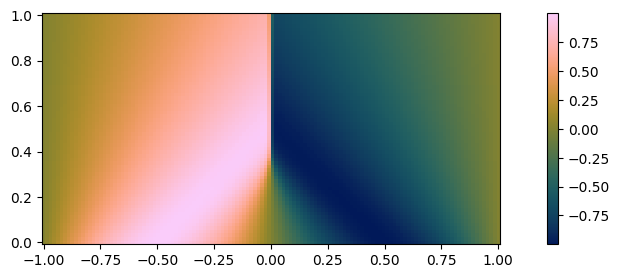

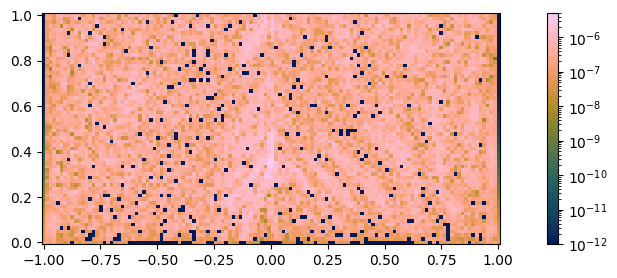

In [6]:
model = eqx.combine(params, static)

u_pred = model.predict(X, T)

error = np.abs(u_solution - u_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_solution = ax.pcolormesh(X, T, u_pred, cmap=cmap)
fig.colorbar(nn_solution, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

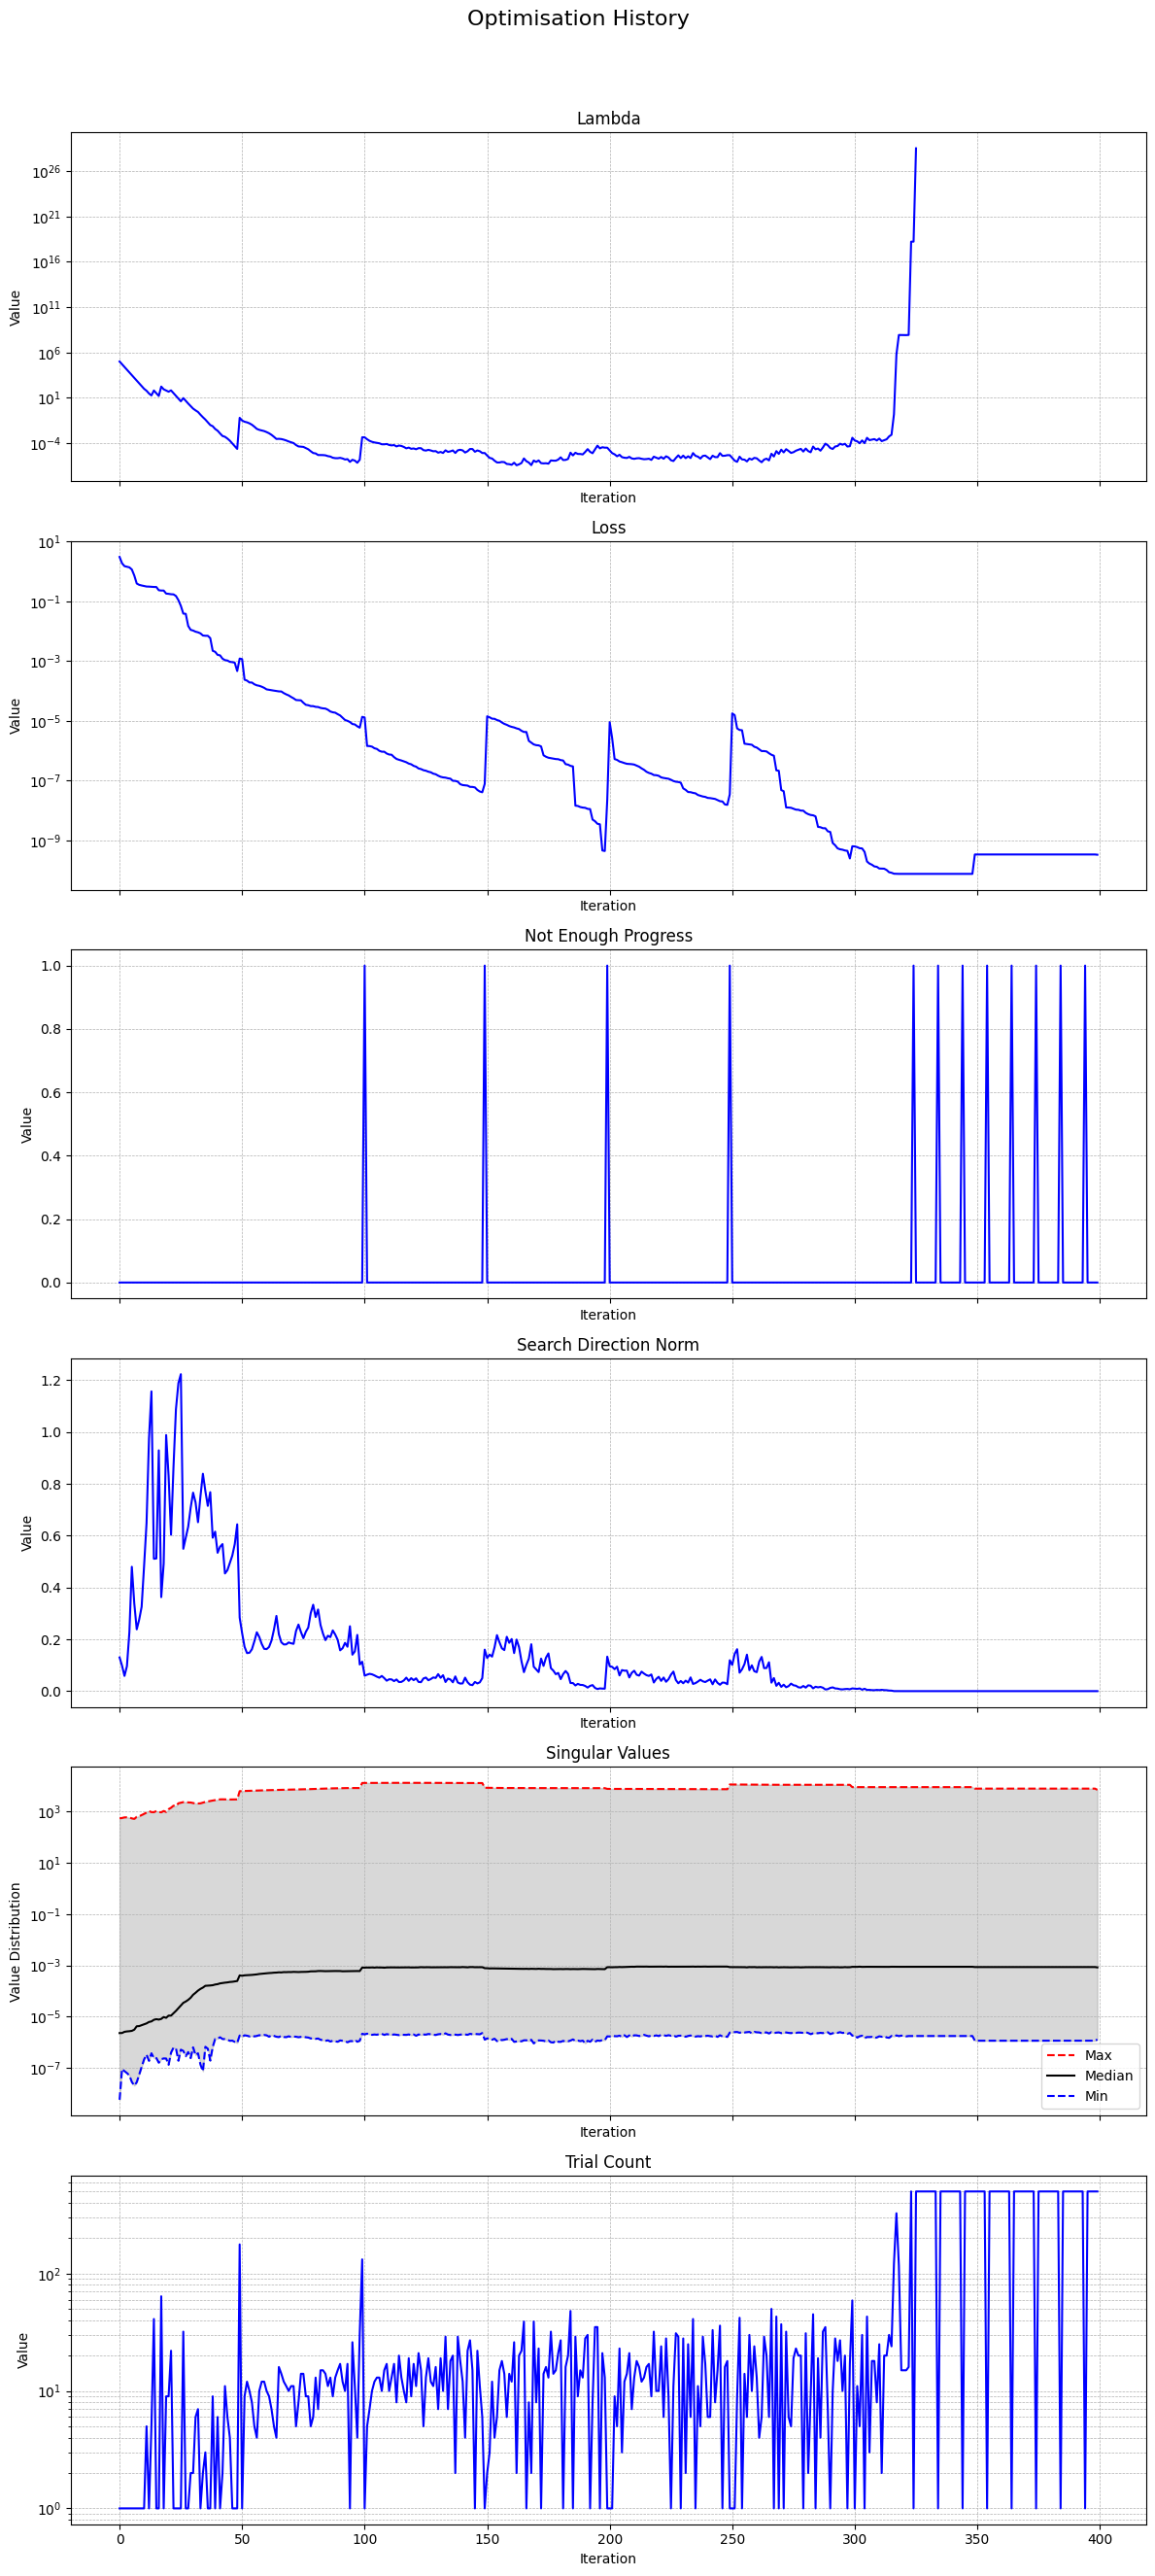

In [7]:
history.plot()